<a href="https://colab.research.google.com/github/vineet891/FODS-Assignment/blob/main/Assignment2/FODS_Assignment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greedy Backward Feature Selection

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

import tqdm
from tqdm import notebook

## Loading Data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/FODS Assignment2/FoDS-Assignment-2.csv')
df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
0,4,1.75,2120.0,7420,1.0,0,0,4,7,1060.0,1060,1540,7420,453000.0
1,4,2.50,2180.0,9861,2.0,0,2,3,8,2180.0,0,2390,9761,480000.0
2,3,1.50,1540.0,9800,1.0,0,0,3,7,1010.0,530,1600,8250,180500.0
3,3,3.50,2380.0,6250,2.0,0,3,3,8,1670.0,710,2540,4010,495000.0
4,4,2.50,2230.0,8500,2.0,0,0,3,8,2230.0,0,2270,8770,325000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,4,2.50,2623.0,7184,2.0,0,0,3,8,2623.0,0,2010,4939,333000.0
1184,2,2.00,1730.0,4248,2.0,0,0,3,7,1730.0,0,1380,4000,450000.0
1185,4,2.50,3040.0,6425,2.0,0,0,3,8,3040.0,0,3040,7800,776000.0
1186,4,1.50,2150.0,11026,1.0,0,0,4,7,2150.0,0,1760,10283,400000.0


## Data Preprocessing

In [ ]:
def preProcess(df):
  df = df.sample(frac=1).reset_index(drop=True)  #shuffle

  df.dropna(inplace=True)   #drop null values

  mu_df = np.mean(df,axis=0) #standardize
  std_df = np.std(df,axis=0)
  df = (df-mu_df)/std_df

  for col in df.columns:     # remove outliers
    df = df[(df[col]<3) & (df[col]>-3)]

  return df

In [ ]:
df = preProcess(df)
df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
1,0.680112,0.472486,0.371249,-0.212465,2.761589,-0.059157,-0.317255,-0.648051,0.269267,0.758652,-0.657051,-1.086020,-0.361716,0.480809
2,-0.398848,0.148552,0.004470,-0.198920,0.910308,-0.059157,-0.317255,-0.648051,-0.583908,0.352386,-0.657051,0.587749,-0.349262,-0.670957
3,-0.398848,0.472486,-0.351828,-0.208832,0.910308,-0.059157,-0.317255,-0.648051,0.269267,-0.332462,-0.108258,-0.925921,-0.400616,-0.274108
5,0.680112,-0.499315,-0.645251,-0.052954,-0.940974,-0.059157,-0.317255,0.875134,-0.583908,-0.947665,0.440535,-0.460176,-0.143407,-0.801517
6,-1.477808,-0.823249,-0.267993,-0.171830,-0.940974,-0.059157,-0.317255,-0.648051,-0.583908,-0.878020,1.099086,-0.445622,-0.286993,-0.100891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,-0.398848,0.472486,0.151182,-0.180595,-0.015333,-0.059157,-0.317255,0.875134,-0.583908,-0.506576,1.274699,-0.212750,-0.305967,0.189959
1184,-0.398848,0.148552,0.255975,-0.014869,-0.940974,-0.059157,-0.317255,0.875134,1.122442,0.630969,-0.657051,1.024384,0.053219,-0.305132
1185,0.680112,0.148552,0.350290,0.739502,0.910308,-0.059157,-0.317255,-0.648051,0.269267,0.735437,-0.657051,0.631412,1.034623,-0.100891
1186,-0.398848,-1.471116,-0.603334,0.351640,-0.940974,-0.059157,-0.317255,0.875134,-0.583908,-0.843197,0.330776,-0.285522,0.419034,-0.310303


In [ ]:
# Train-Test Split
# split the data set into 70:30 train:test 

split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]

In [ ]:
trainSize = train_X[:,-1].size
testSize = test_X[:,-1].size

## Model

In [ ]:
class LinearRegression():

    def __init__(self):
        self.w = None

    def polynomial(self, X):   
        '''
        Evaluates the polynomial by doing a dot product of the weights with the feature variables.
        ''' 
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return np.sum((y-y_pred)**2)/y.shape[0]

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        m = X.shape[0]
        
        return (1/m)*x.T.dot(y_pred - y)
        

    def predict(self, X):
        '''
        Evaluates the polynomial function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)
        print("Testing MSE is ", test_loss)
        rmse_loss = np.sqrt(test_loss)
        print("Testing RMSE is ", rmse_loss)
        return  rmse_loss

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=False, printValues=False):
        '''
          Performs Gradient descent or Stochastic Gradient descent as mentioned.
          Paremeters-
            X - training features
            Y - training target attributes
            epochs - number of iterations the gradient descent should run
            learning - learning rate for gradient update
            display_loss, printValues -  printing loss in each epoch

        '''
        count=0
        m = X.shape[0]

        self.w = np.random.randn(X.shape[1],)

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            
            dw = 0
            if learning == 'GD':

                y_estimated = self.predict(X)
                
                dw = self.grad_w(X, Y)
                self.w = self.w - (learning_rate * dw) 
                
                error = y_estimated - Y
                cost = (1 / 2 * m) * np.sum(error ** 2)             

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                Y_pred = self.predict(X)
                dw = x*(Y_pred[randInt] - y) 
                error = Y_pred - Y

                self.w -= learning_rate * dw

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,  ' RMSE Loss :', np.sqrt(loss[i]))

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Root Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

In [ ]:
def runRegression(train_X,test_X,e,lr,display_loss=False,printValues=False):
  GD1 = LinearRegression()
  GD1.fit(train_X, train_y, epochs = e, learning='GD', learning_rate=lr, display_loss = display_loss,printValues = printValues)
  return GD1.evaluate(test_X, test_y)

In [ ]:
class BestModel:
  def __init__(self, y0, y1):
     self.bestFeatureSet = y0
     self.lowestRMSE = y1

In [ ]:
def SFS(train_X,test_X, train_X_used, test_X_used, featureSet,bestFeatureSet,lowestRMSE,epochs=2000,lr=0.03,j=12):
  if j<1:
    return BestModel(bestFeatureSet,lowestRMSE)
  
  minError= 1   # 0
  feature_to_be_removed=-1
  rmse=1
  for i,(f1,f1t) in enumerate(zip(train_X.T,test_X.T)):
    if (i+1) in featureSet.get(j+1):
      print("\n\nWith out feature ", i+1)
      index_to_insert=-1
      for k,(f2,f2t) in enumerate(zip(train_X_used.T,test_X_used.T)):
        if (f1==f2).all() :
          train_X_used = np.delete(train_X_used, k, axis=1)
          test_X_used = np.delete(test_X_used, k, axis=1)
          print(train_X_used.shape)
          index_to_insert=k
          # break
          rmse = runRegression(train_X_used,test_X_used,epochs,lr)
          featureSet[j]=featureSet[j+1].copy()
          if rmse < minError:
            minError = rmse
            feature_to_be_removed = i+1
          train_X_used=np.insert(train_X_used,index_to_insert,f2,axis=1)
          test_X_used=np.insert(test_X_used,index_to_insert,f2t,axis=1)
  featureSet[j].remove(feature_to_be_removed)

  for i,(f1,f1t) in enumerate(zip(train_X.T,test_X.T)):
    if i+1==feature_to_be_removed:
      for k,(f2,f2t) in enumerate(zip(train_X_used.T,test_X_used.T)):
        if (f1==f2).all() :
          train_X_used = np.delete(train_X_used, k, axis=1)
          test_X_used = np.delete(test_X_used, k, axis=1)

  if(rmse<lowestRMSE):
    lowestRMSE=rmse
    bestFeatureSet = featureSet[j].copy()

  print("Removed feature is ", feature_to_be_removed)
  print(featureSet)
  return SFS(train_X,test_X, train_X_used, test_X_used, featureSet,bestFeatureSet,lowestRMSE,epochs,lr,j-1)
  

In [ ]:
def greedyBackwardFS(train_X,test_X):
  
  featureSet={}
  for i in range(0,14):
    featureSet[i]=set()
  featureSet[13]={1,2,3,4,5,6,7,8,9,10,11,12,13}
  train_X_used = np.append(train_X, np.ones(shape=(trainSize,1)), axis=1)
  test_X_used = np.append(test_X, np.ones(shape=(testSize,1)), axis=1)

  bestFeatureSet =set()
  lowestRMSE=1
  print(featureSet)

  return SFS(train_X,test_X,train_X_used, test_X_used, featureSet,bestFeatureSet,lowestRMSE,3000,0.03,12)

In [ ]:
def BestModelRun(model,test_X,train_X):
  train_X_used = np.ones(shape=(trainSize,))
  test_X_used = np.ones(shape=(testSize,))
  for i,(f1,f1t) in enumerate(zip(train_X.T,test_X.T)):
    if (i+1) in model.bestFeatureSet:
      train_X_used = np.c_[train_X_used, f1]     
      test_X_used = np.c_[test_X_used, f1t]
  return runRegression(train_X_used,test_X_used,3000,0.03,True,True)

## Training

In [ ]:
GBFSRegressionModel = greedyBackwardFS(train_X, test_X)

{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: set(), 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  1
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1721850729415226
Testing RMSE is  0.4149518923218963


With out feature  2
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17752445763987143
Testing RMSE is  0.42133651353742346


With out feature  3
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19341121579508994
Testing RMSE is  0.43978542017112154


With out feature  4
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17270968910125944
Testing RMSE is  0.41558355249126433


With out feature  5
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1732966549169491
Testing RMSE is  0.4162891482094496


With out feature  6
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17244889487289392
Testing RMSE is  0.4152696652452403


With out feature  7
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.201448510911931
Testing RMSE is  0.4488301582023327


With out feature  8
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18009822845821327
Testing RMSE is  0.42437981627100657


With out feature  9
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19612473179184
Testing RMSE is  0.4428597202183102


With out feature  10
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17198800806549036
Testing RMSE is  0.4147143692536953


With out feature  11
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17908245322998723
Testing RMSE is  0.42318134792307094


With out feature  12
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17340821306142365
Testing RMSE is  0.4164231178277974


With out feature  13
(728, 13)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17565198565689377
Testing RMSE is  0.41910856070580776
Removed feature is  10
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: set(), 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  1
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17778739303098812
Testing RMSE is  0.42164842348927156


With out feature  2
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1753273051775241
Testing RMSE is  0.4187210350311101


With out feature  3
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.18856948581991434
Testing RMSE is  0.4342458817535456


With out feature  4
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17262162503664288
Testing RMSE is  0.4154775866838582


With out feature  5
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17316982962709535
Testing RMSE is  0.41613679196520864


With out feature  6
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17987387248153097
Testing RMSE is  0.4241153999579961


With out feature  7
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19952033663444027
Testing RMSE is  0.4466769936256403


With out feature  8
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1957567506719259
Testing RMSE is  0.4424440650205695


With out feature  9
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19742568135099786
Testing RMSE is  0.4443260979854749


With out feature  11
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17582488439578806
Testing RMSE is  0.41931477960571345


With out feature  12
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17620130591342592
Testing RMSE is  0.41976339277434127


With out feature  13
(728, 12)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17576556042687427
Testing RMSE is  0.4192440344559172
Removed feature is  4
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: set(), 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  1
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17285113908384822
Testing RMSE is  0.415753700024243


With out feature  2
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17457380123658497
Testing RMSE is  0.41782029777954177


With out feature  3
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1904469126606902
Testing RMSE is  0.4364022372315364


With out feature  5
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17327706199452012
Testing RMSE is  0.4162656147155565


With out feature  6
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1726949340521466
Testing RMSE is  0.41556579990676157


With out feature  7
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20005957031874969
Testing RMSE is  0.447280192182428


With out feature  8
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17708447512647205
Testing RMSE is  0.4208140624153048


With out feature  9
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.191107983638287
Testing RMSE is  0.4371589912586575


With out feature  11
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1723980464024862
Testing RMSE is  0.41520843729684276


With out feature  12
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17373214436240172
Testing RMSE is  0.41681188126348045


With out feature  13
(728, 11)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17559699786220997
Testing RMSE is  0.41904295467435076
Removed feature is  11
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: set(), 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  1
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1724675557857804
Testing RMSE is  0.4152921330651237


With out feature  2
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17370661645882693
Testing RMSE is  0.4167812573267024


With out feature  3
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19457196356698161
Testing RMSE is  0.4411031212392195


With out feature  5
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.171103851887862
Testing RMSE is  0.4136470136334384


With out feature  6
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17238049034296385
Testing RMSE is  0.4151872954980244


With out feature  7
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2017507152306469
Testing RMSE is  0.4491666898052959


With out feature  8
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1771383972604633
Testing RMSE is  0.420878126374445


With out feature  9
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1903855218603675
Testing RMSE is  0.43633189415898477


With out feature  12
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17311778721066032
Testing RMSE is  0.4160742568468522


With out feature  13
(728, 10)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1753918648675296
Testing RMSE is  0.41879811946513035
Removed feature is  5
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: set(), 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  1
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17142163165239943
Testing RMSE is  0.4140309549446749


With out feature  2
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1724301661327695
Testing RMSE is  0.4152471145387642


With out feature  3
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1929757787245459
Testing RMSE is  0.4392900849376707


With out feature  6
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1710927648261425
Testing RMSE is  0.41363361181865105


With out feature  7
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19914173432747698
Testing RMSE is  0.44625299363419063


With out feature  8
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17428928036956337
Testing RMSE is  0.4174796765946378


With out feature  9
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19294570563763452
Testing RMSE is  0.43925585441475284


With out feature  12
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17179566089123258
Testing RMSE is  0.4144824011839738


With out feature  13
(728, 9)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17443688263234924
Testing RMSE is  0.41765641696536787
Removed feature is  6
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: set(), 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  1
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17130642174392866
Testing RMSE is  0.4138917995611035


With out feature  2
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17248268631612895
Testing RMSE is  0.41531034939684436


With out feature  3
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19302417025268975
Testing RMSE is  0.43934516072524316


With out feature  7
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19907887392231283
Testing RMSE is  0.4461825567212515


With out feature  8
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17432912442396825
Testing RMSE is  0.41752739362102725


With out feature  9
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19291674842377962
Testing RMSE is  0.43922289150701105


With out feature  12
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17187728536662186
Testing RMSE is  0.4145808550411148


With out feature  13
(728, 8)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17443035965976952
Testing RMSE is  0.4176486078748132
Removed feature is  1
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: set(), 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  2
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17311697437883233
Testing RMSE is  0.41607328005873234


With out feature  3
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19418979706045678
Testing RMSE is  0.44066971425372176


With out feature  7
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1997295977459701
Testing RMSE is  0.4469111743355385


With out feature  8
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17419731619140266
Testing RMSE is  0.41736951995971466


With out feature  9
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19391994104150104
Testing RMSE is  0.4403634192817349


With out feature  12
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17208849259301723
Testing RMSE is  0.41483550064214275


With out feature  13
(728, 7)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17463345110230746
Testing RMSE is  0.4178916738848807
Removed feature is  12
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: set(), 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  2
(728, 6)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1739374904629887
Testing RMSE is  0.4170581379891642


With out feature  3
(728, 6)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2051992414214456
Testing RMSE is  0.4529892288139373


With out feature  7
(728, 6)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2008832566875003
Testing RMSE is  0.4482000186161311


With out feature  8
(728, 6)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17456957113857555
Testing RMSE is  0.41781523564678147


With out feature  9
(728, 6)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.2009909739507792
Testing RMSE is  0.4483201690207337


With out feature  13
(728, 6)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17492372830860475
Testing RMSE is  0.4182388412242516
Removed feature is  2
{0: set(), 1: set(), 2: set(), 3: set(), 4: set(), 5: {3, 7, 8, 9, 13}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  3
(728, 5)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20779179590195432
Testing RMSE is  0.4558418540480397


With out feature  7
(728, 5)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20364236106113118
Testing RMSE is  0.4512675049913645


With out feature  8
(728, 5)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.17659202610303662
Testing RMSE is  0.4202285403242343


With out feature  9
(728, 5)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.19986567373546196
Testing RMSE is  0.4470633889455297


With out feature  13
(728, 5)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1762330448951959
Testing RMSE is  0.4198011968720383
Removed feature is  13
{0: set(), 1: set(), 2: set(), 3: set(), 4: {3, 7, 8, 9}, 5: {3, 7, 8, 9, 13}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  3
(728, 4)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20771189234440968
Testing RMSE is  0.4557542016749924


With out feature  7
(728, 4)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20670263832489064
Testing RMSE is  0.4546456183940308


With out feature  8
(728, 4)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.1781035413790473
Testing RMSE is  0.422023152657585


With out feature  9
(728, 4)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20268076751094025
Testing RMSE is  0.45020080798565904
Removed feature is  8
{0: set(), 1: set(), 2: set(), 3: {9, 3, 7}, 4: {3, 7, 8, 9}, 5: {3, 7, 8, 9, 13}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  3
(728, 3)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.21396956974125508
Testing RMSE is  0.46256844870922087


With out feature  7
(728, 3)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20859748715191095
Testing RMSE is  0.45672473893135124


With out feature  9
(728, 3)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.20148609861571892
Testing RMSE is  0.4488720292195972
Removed feature is  9
{0: set(), 1: set(), 2: {3, 7}, 3: {9, 3, 7}, 4: {3, 7, 8, 9}, 5: {3, 7, 8, 9, 13}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


With out feature  3
(728, 2)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.36788058103850074
Testing RMSE is  0.606531599373438


With out feature  7
(728, 2)
Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Testing
Testing MSE is  0.23431781033836047
Testing RMSE is  0.4840638494438109
Removed feature is  7
{0: set(), 1: {3}, 2: {3, 7}, 3: {9, 3, 7}, 4: {3, 7, 8, 9}, 5: {3, 7, 8, 9, 13}, 6: {2, 3, 7, 8, 9, 13}, 7: {2, 3, 7, 8, 9, 12, 13}, 8: {1, 2, 3, 7, 8, 9, 12, 13}, 9: {1, 2, 3, 6, 7, 8, 9, 12, 13}, 10: {1, 2, 3, 5, 6, 7, 8, 9, 12, 13}, 11: {1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13}, 12: {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 13: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}}


In [ ]:
GBFSRegressionModel.lowestRMSE

0.4176486078748132

In [ ]:
GBFSRegressionModel.bestFeatureSet

{2, 3, 7, 8, 9, 12, 13}

Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Epoch: 0  RMSE Loss : 1.9185459035925265
Epoch: 50  RMSE Loss : 0.8385468618254738
Epoch: 100  RMSE Loss : 0.5817735388007029
Epoch: 150  RMSE Loss : 0.5081845295438662
Epoch: 200  RMSE Loss : 0.47905147982805635
Epoch: 250  RMSE Loss : 0.46366774479841366
Epoch: 300  RMSE Loss : 0.4545538290797582
Epoch: 350  RMSE Loss : 0.4489538913330719
Epoch: 400  RMSE Loss : 0.4454539588065199
Epoch: 450  RMSE Loss : 0.4432333080325153
Epoch: 500  RMSE Loss : 0.44180021225306476
Epoch: 550  RMSE Loss : 0.44085738105243705
Epoch: 600  RMSE Loss : 0.44022394755339456
Epoch: 650  RMSE Loss : 0.4397889920276895
Epoch: 700  RMSE Loss : 0.43948376765466896
Epoch: 750  RMSE Loss : 0.439265097651399
Epoch: 800  RMSE Loss : 0.43910543248667144
Epoch: 850  RMSE Loss : 0.43898687254261454
Epoch: 900  RMSE Loss : 0.43889755356039556
Epoch: 950  RMSE Loss : 0.43882944362180387
Epoch: 1000  RMSE Loss : 0.4387769870073865
Epoch: 1050  RMSE Loss : 0.43873625915986997
Epoch: 1100  RMSE Loss : 0.4387044324636357
E

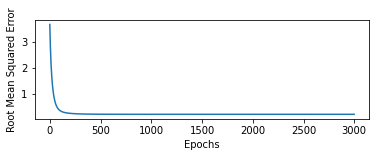

Testing
Testing MSE is  0.17136714969818118
Testing RMSE is  0.41396515517393634


0.41396515517393634

In [ ]:
BestModelRun(GBFSRegressionModel, test_X,train_X)